In [1]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

/home/raven/anaconda3/envs/kawuma/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# Load dataset
data_df = pd.read_csv("/home/raven/Kawuma/Failure Predictor/datasets/Summary_data_system_Failures.csv")
print(f"Dataset shape: {data_df.shape}")
print("\nDataset info:")
print(data_df.info())
print("\nFirst 5 rows:")
print(data_df.head())

Dataset shape: (24, 5)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            24 non-null     int64  
 1   Application     21 non-null     float64
 2   Admision        22 non-null     float64
 3   Academic        20 non-null     float64
 4   student Portal  20 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB
None

First 5 rows:
   year  Application   Admision   Academic  student Portal
0  1996          63.0      100.0      88.0            94.0
1  1997          52.0       78.0      92.0            75.0
2  1998           NaN      100.0     100.0             NaN
3  2000          65.0       80.0      95.0            89.0
4  2001          58.0       87.0      88.0            88.0


In [3]:
data_df.describe()

,year,Application,Admision,Academic,student Portal
count,24.000000,21.000000,22.000000,20.000000,20.000000
mean,2009.541667,54.619048,80.318182,94.900000,82.100000
std,8.792186,17.599648,21.234263,5.046103,13.916669
min,1996.000000,27.000000,0.000000,84.000000,50.000000
25%,2002.750000,38.000000,75.000000,91.500000,75.000000
50%,2008.500000,57.000000,80.000000,95.500000,82.500000
75%,2018.250000,62.000000,93.750000,100.000000,91.750000
max,2024.000000,100.000000,100.000000,100.000000,100.000000


In [4]:
targets = [col for col in data_df.columns if col != "year"]
print("Target columns:", targets)

Target columns: ['Application ', 'Admision ', 'Academic', 'student Portal']


TARGET VARIABLES DISTRIBUTION


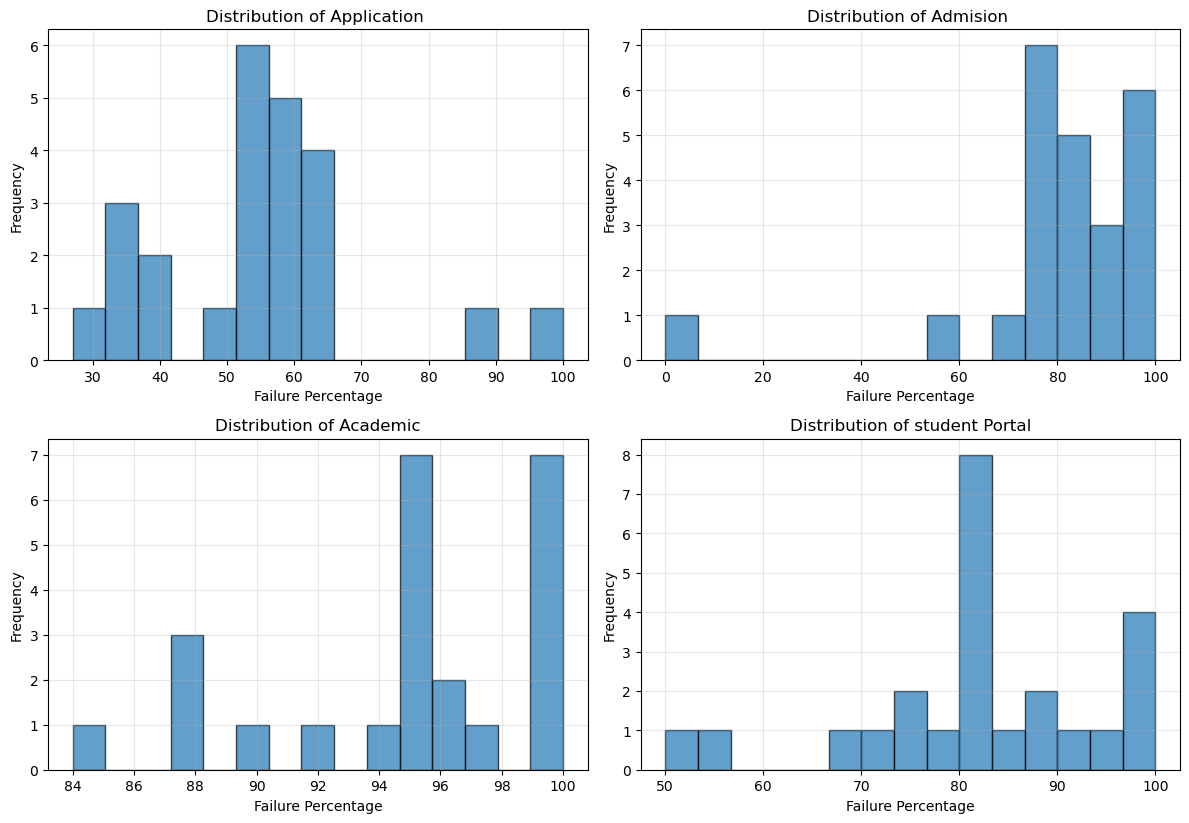

In [20]:
print("TARGET VARIABLES DISTRIBUTION")

plt.figure(figsize=(12, 12))

# Plot distribution of each target variable
for i, target in enumerate(targets, 1):
    plt.subplot(3, 2, i)
    plt.hist(data_df[target], bins=15, alpha=0.7, edgecolor='black')
    plt.xlabel('Failure Percentage')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {target}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Clean the dataset first
data_df.dropna(how='all', inplace=True)
data_df.fillna(data_df.mean(numeric_only=True), inplace=True)

clean_df = data_df.sort_values("year").reset_index(drop=True)

print("Cleaned dataset shape:", clean_df.shape)
print(clean_df.isna().sum())

Cleaned dataset shape: (24, 5)
year              0
Application       0
Admision          0
Academic          0
student Portal    0
dtype: int64


TIME TREND ANALYSIS


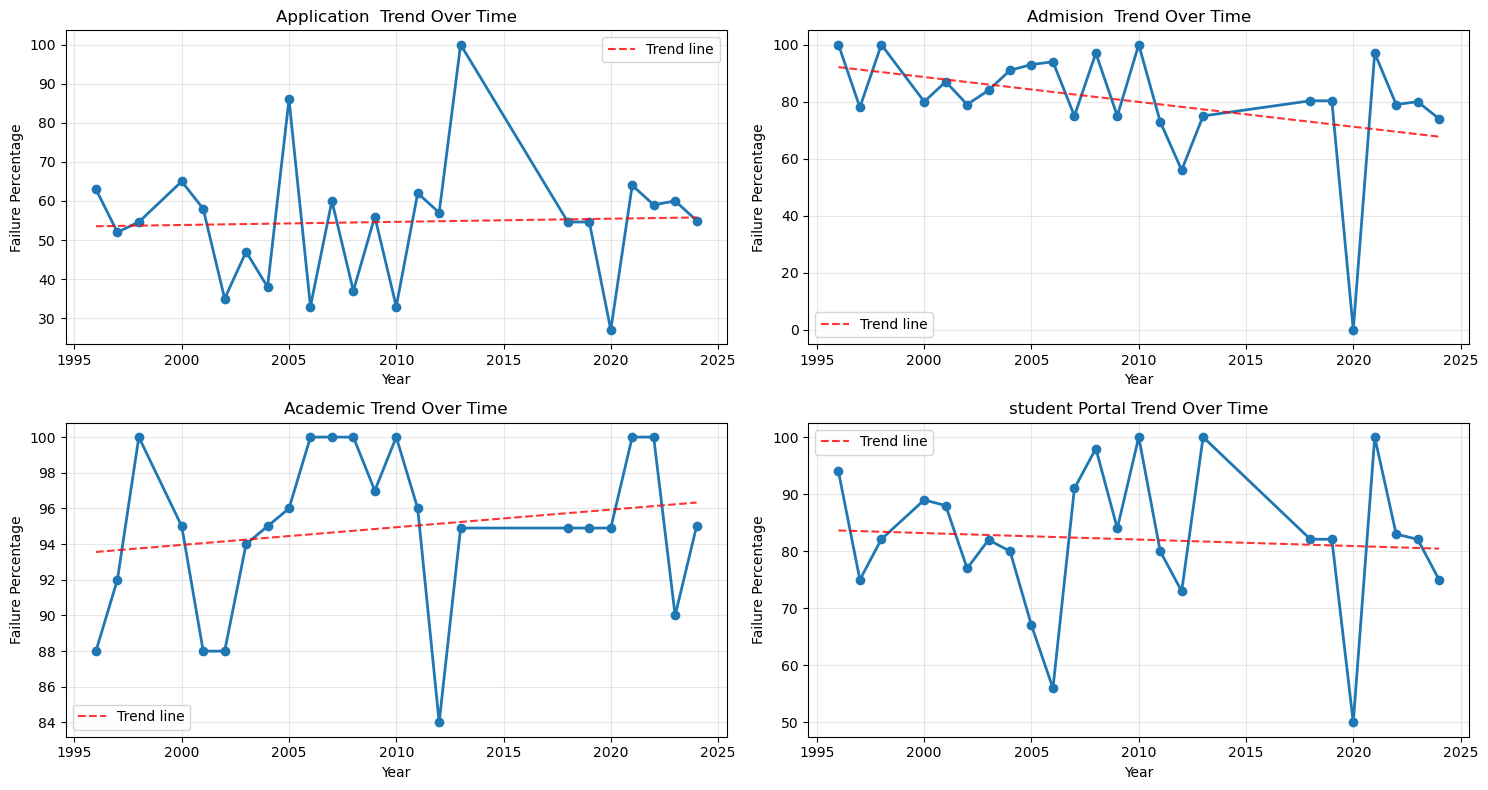

In [23]:
print("TIME TREND ANALYSIS")
plt.figure(figsize=(15, 8))

for i, target in enumerate(targets, 1):
    plt.subplot(2, 2, i)
    plt.plot(clean_df['year'], clean_df[target], 'o-', linewidth=2, markersize=6)
    plt.xlabel('Year')
    plt.ylabel('Failure Percentage')
    plt.title(f'{target} Trend Over Time')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(clean_df['year'], clean_df[target], 1)
    p = np.poly1d(z)
    plt.plot(clean_df['year'], p(clean_df['year']), "r--", alpha=0.8, label='Trend line')
    plt.legend()

plt.tight_layout()
plt.show()

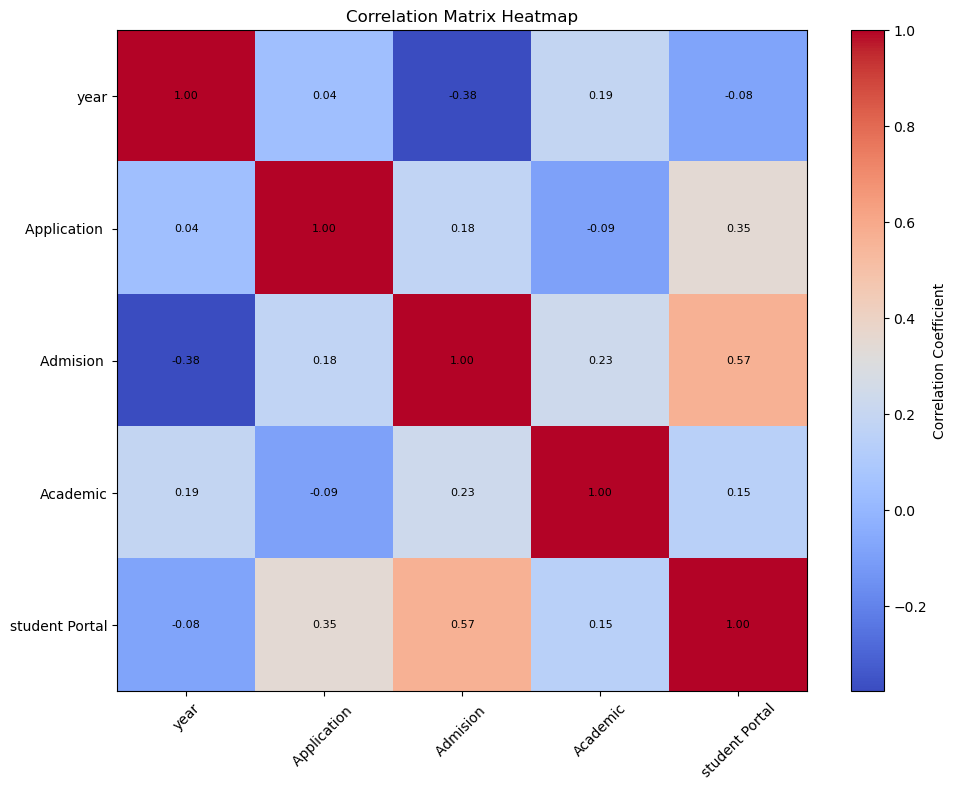


Correlations with Year:
year              1.000000
Academic          0.189658
Application       0.043059
student Portal   -0.079012
Admision         -0.377302
Name: year, dtype: float64


In [6]:
# Calculate correlations between all variables
correlation_matrix = clean_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')

# Add correlation values as text
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print correlations with year
print("\nCorrelations with Year:")
year_correlations = correlation_matrix['year'].sort_values(ascending=False)
print(year_correlations)

In [7]:
# Split the dataset
X = clean_df["year"].values.reshape(-1, 1)

In [8]:
# Train xgboost regression models and predict future failures

models = {}
future_years = np.arange(2026, 2036).reshape(-1, 1)
future_predictions = {}
alpha = 0.7

for target in targets:
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    xgb_model.fit(X, clean_df[target])

    # Linear Regression Model
    lin_model = LinearRegression()
    lin_model.fit(X, clean_df[target])

    xgb_pred = xgb_model.predict(future_years)
    lin_pred = lin_model.predict(future_years)

    blended_pred = alpha * xgb_pred + (1 - alpha) * lin_pred
    
    models[target] = {"xgb": xgb_model, "linear": lin_model}
    future_predictions[target] = blended_pred



In [9]:
forecast_df = pd.DataFrame({"Year": future_years.flatten()})
for target in targets:
    forecast_df[target] = future_predictions[target].round(2)

print("Forecast for 2026–2035 (Hybrid XGBoost + Linear):")
print(forecast_df)

Forecast for 2026–2035 (Hybrid XGBoost + Linear):
   Year  Application   Admision   Academic  student Portal
0  2026         55.43      71.70     95.42           76.78
1  2027         55.45      71.44     95.45           76.74
2  2028         55.48      71.18     95.48           76.71
3  2029         55.50      70.92     95.51           76.68
4  2030         55.53      70.66     95.54           76.64
5  2031         55.55      70.39     95.57           76.61
6  2032         55.57      70.13     95.59           76.57
7  2033         55.60      69.87     95.62           76.54
8  2034         55.62      69.61     95.65           76.51
9  2035         55.65      69.35     95.68           76.47


In [10]:
for target in targets:
    y_true = clean_df[target]
    xgb_pred = models[target]["xgb"].predict(X)
    lin_pred = models[target]["linear"].predict(X)
    y_pred = alpha * xgb_pred + (1 - alpha) * lin_pred

    print(f"{target} R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"{target} MAE Score: {mean_squared_error(y_true, y_pred):.4f}\n")


Application  R² Score: 0.8994
Application  MAE Score: 25.9568

Admision  R² Score: 0.9171
Admision  MAE Score: 32.7151

Academic R² Score: 0.9085
Academic MAE Score: 1.8437

student Portal R² Score: 0.9012
student Portal MAE Score: 15.1477



In [21]:
# Fixed plotting code
plt.figure(figsize=(15, 10))

for i, target in enumerate(targets):
    xgb_fit = models[target]["xgb"].predict(X)
    lin_fit = models[target]["linear"].predict(X)
    hybrid_fit = alpha * xgb_fit + (1 - alpha) * lin_fit
    
    plt.subplot(2, 3, i+1)  # Create subplots for each target
    plt.plot(clean_df["year"], clean_df[target], 'o-', label=f"Actual")
    plt.plot(clean_df["year"], hybrid_fit, '-', label=f"Fitted")
    plt.plot(future_years, future_predictions[target], '--', label=f"Forecast")
    plt.xlabel("Year")
    plt.ylabel("Failure Percentage")
    plt.title(f"{target} Forecast")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

KeyError: 'Application'

<Figure size 1500x1000 with 0 Axes>

In [ ]:

plt.figure(figsize=(10, 8))

for target in targets:
    plt.plot(future_years, future_predictions[target], 'o', label=f"{target} (Forecast)")

plt.xlabel("Year")
plt.ylabel("Failure Percentage")
plt.title("AIMS System Failure Forecast (XGBoost Model)")
plt.legend()
plt.grid(True)
plt.show()


R² Scores DataFrame:
                XGBoost  Hybrid  Linear Regression
Application      0.9988  0.8994             0.0019
Admision         0.9995  0.9171             0.1424
Academic         0.9998  0.9085             0.0360
student Portal   0.9992  0.9012             0.0062

MAE Scores DataFrame:
                XGBoost   Hybrid  Linear Regression
Application      0.2993  25.9568           257.6444
Admision         0.1816  32.7151           338.3679
Academic         0.0050   1.8437            19.4332
student Portal   0.1199  15.1477           152.3678


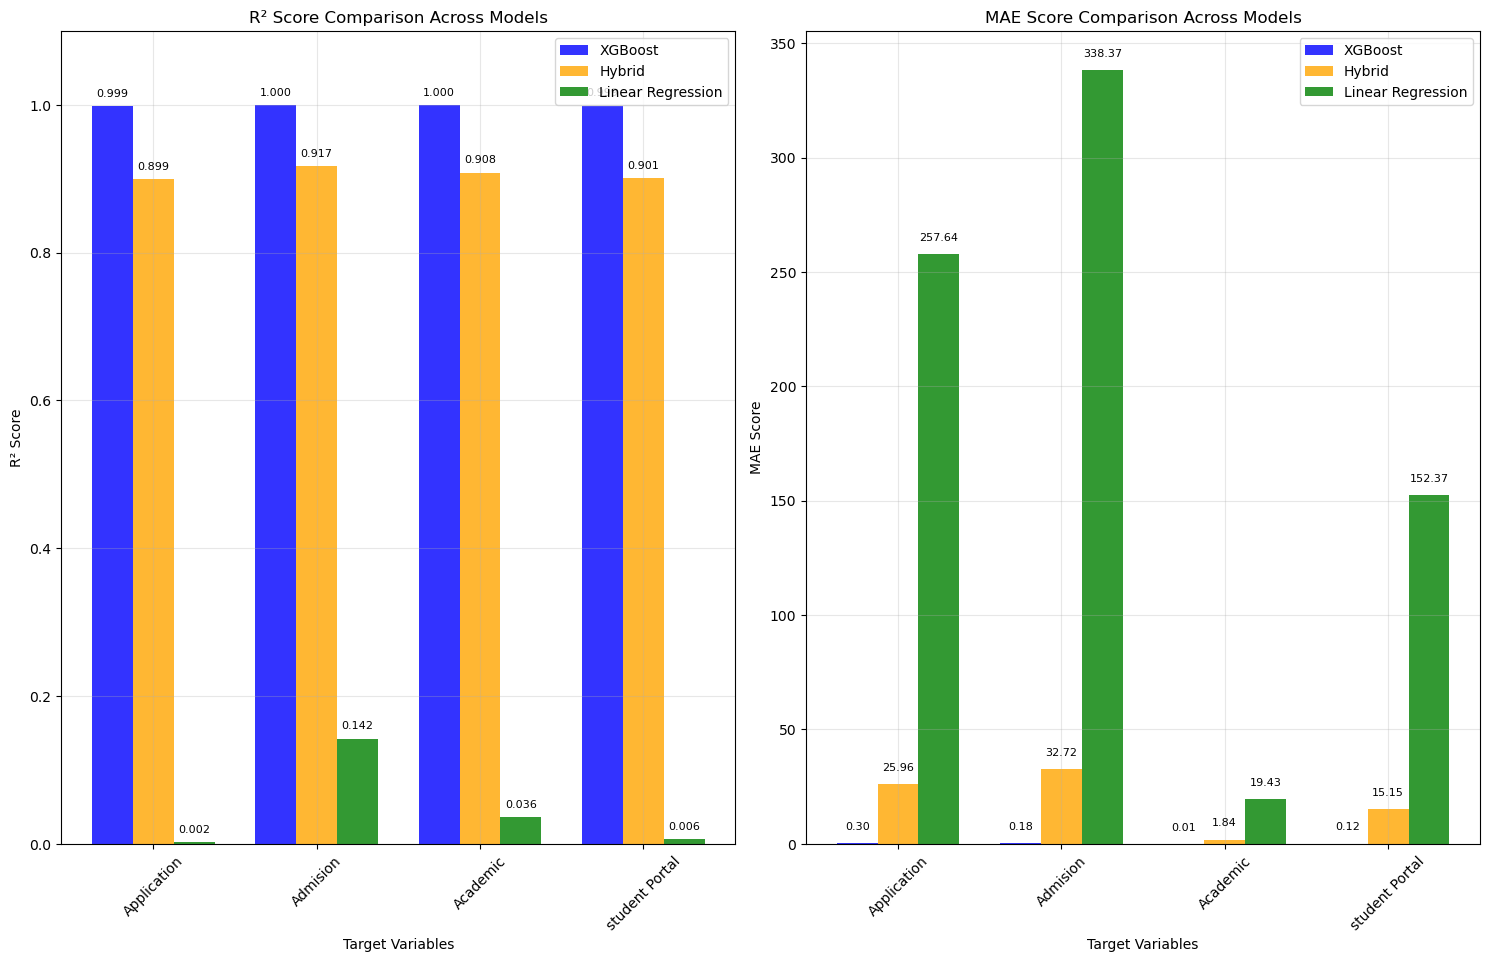